In [1]:
import pandas as pd
import os

# mac.osで動かすためのおまじない
os.environ['KMP_DUPLICATE_LIB_OK']='True'

base_dir = "mini_pictures"
train_dir = os.path.join(base_dir,"train")
valid_dir = os.path.join(base_dir,"valid")
test_dir = os.path.join(base_dir,"test")
mini_metadata = pd.read_csv('mini_metadata.csv',index_col=0)
classes = list(mini_metadata["make_model"].value_counts().index)
classes = sorted(classes)
classes_num = len(mini_metadata.groupby("make_model"))
print(classes)
print(classes_num)
# mini_metadata.groupby("make_model").nunique()
print(mini_metadata["make_model"].value_counts())

['Audi-a3', 'Audi-a5', 'Audi-q5', 'BMW-1-series', 'BMW-x5', 'Honda-pilot', 'Lexus-is-250', 'MINI-countryman', 'Mazda-mazda5', 'Mercedes-Benz-gla', 'Mercedes-Benz-m-class', 'Mitsubishi-outlander', 'Nissan-370z', 'Nissan-rogue-select', 'Subaru-forester', 'Subaru-outback', 'Subaru-xv-crosstrek', 'Toyota-prius-plug-in-hybrid', 'Volkswagen-cc', 'Volvo-xc60']
20
BMW-x5                         13
Subaru-forester                12
Mercedes-Benz-m-class          12
Audi-q5                        11
Mercedes-Benz-gla              11
Audi-a3                        11
Toyota-prius-plug-in-hybrid    11
MINI-countryman                11
Volkswagen-cc                  11
Mazda-mazda5                   11
Honda-pilot                    10
Nissan-370z                    10
Mitsubishi-outlander           10
BMW-1-series                    9
Audi-a5                         9
Nissan-rogue-select             8
Subaru-outback                  8
Lexus-is-250                    8
Volvo-xc60                   

In [2]:
from keras import layers
from keras import models

# 特徴を抽出
# model.add(layers.Conv2D(フィルターの種類の数, (フィルターの大きさ), activation='活性化関数',
#                input_shape=ここの中身はいじらない(縦, 横, 色の数(奥行き))))
model_3_1 = models.Sequential()
model_3_1.add(layers.Conv2D(32, (3, 3), activation='relu',
                       input_shape=(256, 256, 3)))
# 過学習を防ぐためMaxPooling2Dで大事そうなやつだけにして情報を減らす
model_3_1.add(layers.MaxPooling2D((2, 2)))
model_3_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3_1.add(layers.MaxPooling2D((2, 2)))
model_3_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3_1.add(layers.MaxPooling2D((2, 2)))
model_3_1.add(layers.Conv2D(128, (3, 3), activation='relu'))

model_3_1.add(layers.Conv2D(32, (3, 3),strides=(2, 2),activation='relu'))
model_3_1.add(layers.MaxPooling2D((2, 2)))
model_3_1.add(layers.Dropout(0.3))
# 特徴をもとにどのクラスに分類するのかの識別器
model_3_1.add(layers.Flatten())
# denseは全結合、情報を圧縮する。最初の引数は圧縮した後の数
model_3_1.add(layers.Dense(256, activation='relu'))
model_3_1.add(layers.Dense(classes_num, activation='softmax'))

Using TensorFlow backend.
/Users/tatsuki/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/tatsuki/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/tatsuki/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/tatsuki/opt/anaconda3/lib/pytho






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
model_3_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       147584    
__________

In [4]:
from keras import optimizers

# categorical_crossentropy,lr=学習率
# entropyは情報の不確かさの尺度で小さいほど、確かっぽい感じがする
# entropyを使うことで不確かが数値で計算ができるのがよき
# これをめちゃくちゃ小さくできれば多分確からしいからそこを目指したい
model_3_1.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=1e-4),
             metrics=['acc'])

In [5]:
from keras.preprocessing.image import ImageDataGenerator
#すべての画像を1/255スケーリング(大きさではなくて光の大きさ)
# deeplearningは計算して重みの更新をするから使う数値は小さい方が良い
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#flow_from_directoryでは、categoricalのラベリングにclassesを参照して、ディレクトリ名から自動的にone-hotエンコードされる
# ここは頑張りましょう、flow_from_directoryと検索したり、本読んだり
train_generator = train_datagen.flow_from_directory(
    train_dir,               #ターゲットディレクトリ
    target_size=(256, 256),  #すべての画像サイズを256*256に変換
    batch_size=32,           #バッチサイズ
    class_mode='categorical',
    classes=classes)#categorical_crossentropyを使用するため多クラスラベルが必要

validation_generator = test_datagen.flow_from_directory(
    valid_dir,               #ヴァリデーションディレクトリ
    target_size=(256, 256),  #すべての画像サイズを256*256に変換
    batch_size=32,           #バッチサイズ、重りの更新をするときになんかごとに重りを変更するか的な
    class_mode='categorical',
    classes=classes)#categorical_crossentropyを使用するため多クラスラベルが必要






Found 1917 images belonging to 20 classes.
Found 636 images belonging to 20 classes.


In [6]:
history = model_3_1.fit_generator(train_generator,
                             steps_per_epoch=1917//32,
                             epochs=30,
                             validation_data=validation_generator,
                             validation_steps=636//32)
import json
with open('stride2_mini_history.json', 'w') as f:
    json.dump(history.history, f)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
59/59 [==============================] - 191s 3s/step - loss: 2.9936 - acc: 0.0482 - val_loss: 2.9728 - val_acc: 0.1135
Epoch 2/30
59/59 [==============================] - 182s 3s/step - loss: 2.9829 - acc: 0.0674 - val_loss: 2.9670 - val_acc: 0.0530
Epoch 3/30
59/59 [==============================] - 179s 3s/step - loss: 2.9689 - acc: 0.0796 - val_loss: 2.9292 - val_acc: 0.1523
Epoch 4/30
59/59 [==============================] - 180s 3s/step - loss: 2.9186 - acc: 0.1046 - val_loss: 2.8299 - val_acc: 0.1507
Epoch 5/30
59/59 [==============================] - 179s 3s/step - loss: 2.7892 - acc: 0.1444 - val_loss: 2.6790 - val_acc: 0.1854
Epoch 6/30
59/59 [==============================] - 178s 3s/step - loss: 2.6359 - acc: 0.1978 - val_loss: 2.5042 - val_acc: 0.2450
Epoch 7/30
59/59 [==============================] - 180s 3s/step - loss: 2.4354 - acc: 0.2636 - val_loss: 2.3602 - val_a

In [7]:
import json
f = open('stride2_mini_history.json', 'r')
history = json.load(f)
f.close()

In [8]:
model_3_1.save("stride2_mini.h5")

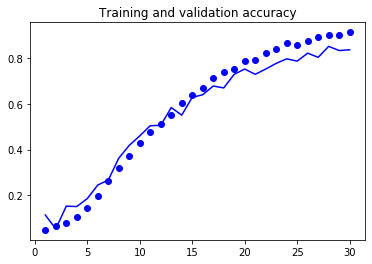

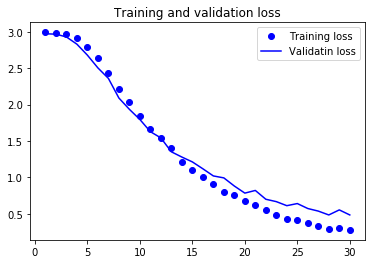

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1,len(acc)+1)

#正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')



#損失値をプロット
plt.figure()# 2枚目の図の下地
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validatin loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
history = model_3_1_100.fit_generator(train_generator,
                             steps_per_epoch=1917//32,
                             epochs=30,
                             validation_data=validation_generator,
                             validation_steps=636//32)
import json
with open('stride2_ep100_mini_history.json', 'w') as f:
    json.dump(history.history, f)